### Prohibited Comment Classification 

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

This notebook is inspired by an exercise from the course [NLP Course | For You](https://lena-voita.github.io/nlp_course.html). </p>       
__In this notebook__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [3]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

In [4]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [5]:
texts_train[0::100]

array(['... oh and what kind of person WATCHES another persons mytalk page? Stalker!',
       "Hey, you are preaching to the choir here, dude )  Remember this one?  I couldn't find anything solid about it at the time (except for that NTV gag report).  How tempting it must have been to assume the place is not notable beyond its funny name, eh?  Well, eat this!  The site itself is hardly a reliable source, but it's a very good illustration of what kind of information is available out there.  And every other shabby-Russian-village-population-five is going to have at least as much written about it over the years.  It's not that there are no sources, it's that there are often no easily accessible sources.  What that is so hard to understand to some is beyond me.—\xa0•\xa0(yo?); May\xa019, 2010; 21:47 (UTC)",
       'DCANDETO SMELLS FUNNY! HE IS VERY MEAN!',
       'suicides\n\njust looking at this article make me want to commit suicide.',
       'Caps \n\nSeems like Demon Core should be cap

In [6]:
# task: preprocess each comment in train and test

#np.apply_along_axis(preprocess, 0, texts_train)
#texts_test = preprocess(texts_test)
texts_train = np.vectorize(preprocess) (texts_train)
texts_test =  np.vectorize(preprocess) (texts_test)

In [7]:
texts_train[0::100]

array(['... oh and what kind of person watches another persons mytalk page ? stalker !',
       "hey , you are preaching to the choir here , dude ) remember this one ? i couldn't find anything solid about it at the time ( except for that ntv gag report ) . how tempting it must have been to assume the place is not notable beyond its funny name , eh ? well , eat this ! the site itself is hardly a reliable source , but it's a very good illustration of what kind of information is available out there . and every other shabby-russian-village-population-five is going to have at least as much written about it over the years . it's not that there are no sources , it's that there are often no easily accessible sources . what that is so hard to understand to some is beyond me . — • ( yo ? ); may 19 , 2010 ; 21:47 ( utc )",
       'dcandeto smells funny ! he is very mean !',
       'suicides just looking at this article make me want to commit suicide .',
       'caps seems like demon core should b

In [8]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. Please don't do that in the current assignment, though.
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [9]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = 10000

# Build vocabulary
word2index = {}
word2count = {}
index2word = {}
num_words = 0
for t in texts_train: 
    #tok = tokenizer.tokenize(t)
    tok = set(t.split())
    for tk in tok: 
        if tk not in word2index:
            word2index[tk] = num_words
            word2count[tk] = 1
            index2word[num_words] = tk           
            num_words += 1
        else:
             word2count[tk] += 1

word2count = dict(sorted(word2count.items(), key=lambda item: item[1], reverse = True) [:k])
        
bow_vocabulary = list(word2count.keys())

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', '←']


In [10]:
max_len = len(set(' '.join(texts_train).split()))
max_len

5707

In [13]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    #<YOUR CODE>
#     tok = set(tokenizer.tokenize(text))
    ltk = [0]* max_len
    #print(len(ltk))
    for tk in set(text.split()):
        try:
            #ltk.append(text.split().count(tk))
            ltk[bow_vocabulary.index(tk)] = text.split().count(tk)
        except ValueError:
            #ltk.append(0)
            #print ( tk + " Not in Vocab")
            pass
    
    #max_len = 5000
    #print(len(ltk))
    #return np.array(np.lib.pad(ltk, (0, max_len - len(ltk)), 'constant', constant_values=0), 'float32')
    #print ( max_len)
    return np.array(ltk, 'float32')

In [14]:
np.stack(list(map(text_to_bow, texts_train)))

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 9.,  3.,  6., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 4.,  5.,  4., ...,  0.,  0.,  0.],
       [35., 35.,  0., ..., 35.,  0.,  0.],
       [ 2.,  1.,  0., ...,  0.,  1.,  1.]], dtype=float32)

In [61]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [16]:
X_train_bow[5:10].sum(-1)

array([  9., 202.,  15.,  51.,  41.], dtype=float32)

In [17]:
[len(s.split()) for s in  texts_train[5:10]]

[9, 202, 15, 51, 41]

In [18]:
texts_train[6]

'" alright , i am willing to concede that the cia allegations are flimsy at best , therefore , i will stop the edit warring . while you may not consider it too important , i think the issue of assange as the founder to be another example of lazy journalism . your source for assange as founder of wikleaks was msnbc.com . i don\'t necessarily consider msnbc to be a reliable source most of the time . corporate news does not do " " real " " journalism . they copy news from one source or they make stories up . it seems to me that the idea of assange as founder is a meme . i have never read a quote from assange whereby he states that he founded wikileaks . this idea seems to be mostly promulgated by the u . s . corporate media . perhaps to vilify him in the minds of americans , so that later he can be lynched . this seems like propaganda 101 to me . the wikileaks site does not identify assange as the founder . where is the evidence ? thc loadee 04:08 , 4 march 2011 ( utc ) "'

In [21]:
len(bow_vocabulary)

5707

In [24]:
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

#### Naive bayes
__Naive bayes:__ perhaps the simplest model that can solve your problem is the so called Naive Bayes Classifier. 
Its a trivial linear model that assumes the independence of input features and computes the coefficients by, well, counting probabilities.

If you don't remember the math behind Naive Bayes, read [this chunk](https://lena-voita.github.io/nlp_course/text_classification.html#naive_bayes) to help refresh your memory. Done? Good! Now let's implement that :)

In [27]:
class BinaryNaiveBayes:
    delta = 1.0  # add this to all word counts to smoothe probabilities
    
    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        # first, compute marginal probabilities of every class, p(y=k) for k = 0,1
        #self.p_y = np.array(<YOUR CODE: probability of y=0 and of y=1 in that order>)
        self.p_y = np.array([(y == 0).sum()/((y == 0).sum() + (y== 1).sum()), (y == 1).sum()/((y == 0).sum() + (y== 1).sum())])
        
        # count occurences of each word in texts with label 0 and label 1 separately
        word_counts_positive = X[ y == 0].sum(axis=0)
        word_counts_negative = X[ y == 1].sum(axis=0)
        # ^-- both must be vectors of shape [vocab_size].
        
        # finally, lets use those counts to estimate p(x | y = k) for k = 0, 1
        
        #<YOUR CODE HERE>
        self.p_x_given_positive = (word_counts_positive + self.delta) / (word_counts_positive.sum() + self.delta * len(X[0]))
        self.p_x_given_negative = (word_counts_negative + self.delta )/ (word_counts_negative.sum() + self.delta * len(X[0]))

        # both must be of shape [vocab_size]; and don't forget to add self.delta!
        
        return self
    
    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """
        # compute scores for positive and negative classes separately.
        # these scores should be proportional to log-probabilities of the respective target {0, 1}
        # note: if you apply logarithm to p_x_given_*, the total log-probability can be written
        # as a dot-product with X
        #score_negative = <YOUR CODE HERE - compute unnormalized negative log-probability>
        score_negative = np.dot(X, np.log(self.p_x_given_negative))
        score_positive = np.dot(X, np.log(self.p_x_given_positive))
        
        # you can compute total p(x | y=k) with a dot product
        #return np.stack([score_negative, score_positive], axis=-1)
        return np.stack([score_positive, score_negative], axis=-1)
    
    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)

In [28]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

In [30]:
naive_model.p_x_given_negative.sum()
#np.allclose()

1.0

In [34]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

f_index = bow_vocabulary.index('fuck')  # offensive tweets should contain more of this
assert naive_model.p_x_given_positive[f_index] < naive_model.p_x_given_negative[f_index]

g_index = bow_vocabulary.index('good')  # offensive tweets should contain less of this
assert naive_model.p_x_given_positive[g_index] > naive_model.p_x_given_negative[g_index]

In [35]:
naive_model.p_x_given_positive[f_index]

3.427592e-05

In [36]:
naive_model.p_x_given_negative[f_index]

0.0018433952

Model accuracy: 0.756
Well done!


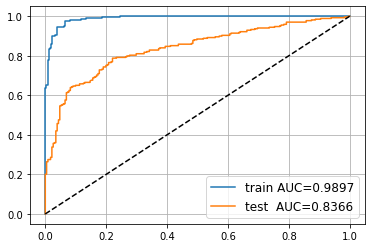

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

Okay, it definitely learned *something*. Now let's figure out what exactly it learned. The simplest way to do that is by highlighting which words have a greatest ratio of positive to negative probability or vice versa. We'll go with the negative one [because reasons](https://www.urbandictionary.com/define.php?term=because%20reasons).

__Your task__ is to compute top-25 words that have the __highest__ ratio of ${p(x_i | y=1)} \over {p(x_i | y=0)}$. Enjoy!

In [38]:
# hint: use naive_model.p_*
#probability_ratio = <YOUR CODE: compute the ratio as defined above, must be a vector of [vocab_size]>
probability_ratio = naive_model.p_x_given_negative/naive_model.p_x_given_positive
#top_negative_words = <YOUR CODE: find 25 words with highest probability_ratio, return list of str>
# We have to use the list slicing [:-26:-1] to get the 25 highest values as argsort sorts from lower to higher
top_negative_words = [bow_vocabulary[s] for s in (probability_ratio).argsort()[:-26:-1].tolist()]

assert len(top_negative_words) == 25 and [isinstance(w, str) for w in top_negative_words]
assert 'j.delanoy' in top_negative_words and 'college' in top_negative_words

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[bow_vocabulary.index(word)]})")

#0	    hitler	(ratio=475.47344970703125)
#1	      heil	(ratio=471.8065185546875)
#2	   offfuck	(ratio=441.2491149902344)
#3	      suck	(ratio=314.7414245605469)
#4	    nigger	(ratio=223.6802978515625)
#5	 j.delanoy	(ratio=220.01341247558594)
#6	      dick	(ratio=187.0113983154297)
#7	      fggt	(ratio=97.78373718261719)
#8	     bitch	(ratio=59.89254379272461)
#9	      fuck	(ratio=53.78105545043945)
#10	      shit	(ratio=44.002681732177734)
#11	      slap	(ratio=44.002681732177734)
#12	   fucking	(ratio=31.779714584350586)
#13	       ass	(ratio=26.890527725219727)
#14	    stupid	(ratio=18.33445167541504)
#15	         =	(ratio=17.53995704650879)
#16	   college	(ratio=17.11215591430664)
#17	         *	(ratio=17.11215591430664)
#18	   asshole	(ratio=15.889857292175293)
#19	         u	(ratio=15.278709411621094)
#20	   bastard	(ratio=14.667561531066895)
#21	       hit	(ratio=14.667561531066895)
#22	     idiot	(ratio=13.445263862609863)
#23	         @	(ratio=13.445263862609863)
#24	 beautiful

#### Logistic Regression
Now lets try something less prehistoric: __Logistic Regression__. Turns out, if you're using silicon instead of an abacus, you can find model weights by optimizing the log-probability of the answer. Though, of course, you don't even need to write it by hand anymore. Let's sklearn it!

In [39]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression(C = 0.2)
bow_model.fit(X_train_bow, y_train)

LogisticRegression(C=0.2)

Model accuracy: 0.772
Well done!


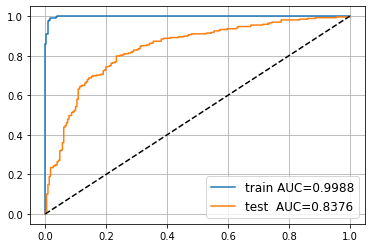

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }} $$


, where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :) You can still use 'em for debugging though.

In [148]:
n_train = len(texts_train)
n_train

500

In [155]:
def text_to_tfidf(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    #<YOUR CODE>
#     tok = set(tokenizer.tokenize(text))
    lalpha = 1.0
    ltk = [0]* max_len
    #print(len(ltk))
    for tk in set(text.split()):
        try:
            #ltk.append(text.split().count(tk))
            if (bow_vocabulary.index(tk) != -1): 
                ltk[bow_vocabulary.index(tk)] = text.split().count(tk)*np.log(n_train/(word2count[tk] + lalpha))
            
        except ValueError:
            #ltk.append(0)
            #print ( tk + " Not in Vocab")
            pass
    
    #max_len = 5000
    #print(len(ltk))
    #return np.array(np.lib.pad(ltk, (0, max_len - len(ltk)), 'constant', constant_values=0), 'float32')
    #print ( max_len)
    return np.array(ltk, 'float32')

In [156]:
np.stack(list(map(text_to_tfidf, texts_train)))

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  2.3522828 ,   1.6238545 ,   3.2890885 , ...,   0.        ,
          0.        ,   0.        ],
       [  0.26136476,   0.        ,   0.5481814 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.045459  ,   2.7064242 ,   2.1927257 , ...,   0.        ,
          0.        ,   0.        ],
       [  9.147767  ,  18.94497   ,   0.        , ..., 193.25113   ,
          0.        ,   0.        ],
       [  0.5227295 ,   0.54128486,   0.        , ...,   0.        ,
          5.521461  ,   5.521461  ]], dtype=float32)

In [194]:
X_train_tfidf = np.stack(list(map(text_to_tfidf, texts_train)))
X_test_tfidf = np.stack(list(map(text_to_tfidf, texts_test)))

In [195]:
X_train_tfidf
#word2count['user_talk']
#bow_vocabulary.index('user_talk')

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  2.3522828 ,   1.6238545 ,   3.2890885 , ...,   0.        ,
          0.        ,   0.        ],
       [  0.26136476,   0.        ,   0.5481814 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.045459  ,   2.7064242 ,   2.1927257 , ...,   0.        ,
          0.        ,   0.        ],
       [  9.147767  ,  18.94497   ,   0.        , ..., 193.25113   ,
          0.        ,   0.        ],
       [  0.5227295 ,   0.54128486,   0.        , ...,   0.        ,
          5.521461  ,   5.521461  ]], dtype=float32)

In [196]:
# Normalization 
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
# define standard scaler
normalizer = Normalizer()
# transform data
X_train_tfidf = normalizer.fit_transform(X_train_tfidf)
X_test_tfidf = normalizer.transform(X_test_tfidf)

In [197]:
X_train_tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05254224, 0.03627155, 0.07346739, ..., 0.        , 0.        ,
        0.        ],
       [0.01808556, 0.        , 0.0379323 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0318519 , 0.08245636, 0.06680556, ..., 0.        , 0.        ,
        0.        ],
       [0.02466113, 0.05107304, 0.        , ..., 0.52097857, 0.        ,
        0.        ],
       [0.03155504, 0.03267515, 0.        , ..., 0.        , 0.33330798,
        0.33330798]], dtype=float32)

In [198]:
tfidf_model = LogisticRegression(C=5.0)
tfidf_model.fit(X_train_tfidf, y_train)

LogisticRegression(C=5.0)

Bow Model accuracy: 0.772
tfidf Model accuracy: 0.798
Well done!


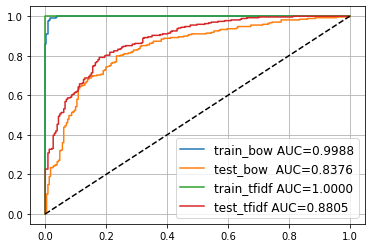

In [199]:
for name, X, y, model in [
    ('train_bow', X_train_bow, y_train, bow_model),
    ('test_bow ', X_test_bow, y_test, bow_model),
    ('train_tfidf', X_train_tfidf, y_train, tfidf_model),
    ('test_tfidf', X_test_tfidf, y_test, tfidf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

bow_test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
tfidf_test_accuracy = np.mean(tfidf_model.predict(X_test_tfidf) == y_test)
print(f"Bow Model accuracy: {bow_test_accuracy:.3f}")
print(f"tfidf Model accuracy: {tfidf_test_accuracy:.3f}")
#assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

We notice that the model with the tfidf features is more accurate than the model with bow features:    
* Acurracy of 0.798 compared to 0.772
* AUC of 0.8805 compared to 0.8376 on the test set

Let's check that we have the same kind of result with the sklearn TfidfVectorizer


In [200]:
# Import the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

In [201]:
vect = TfidfVectorizer(max_features=6000).fit(texts_train) 
X_train_sk_tfidf= vect.transform(texts_train) 
X_test_sk_tfidf= vect.transform(texts_test)

In [202]:
X_train_sk_tfidf.toarray().shape

(500, 5486)

In [203]:
print(vect.get_feature_names() [:300])

['00', '000', '000000', '000428', '006', '01', '01rius', '03', '04', '05', '06', '07', '08', '084080', '09', '0px', '10', '100', '1000', '100s', '101', '105', '11', '117', '119', '11th', '12', '121', '122', '123', '124', '127', '128', '12th', '13', '13000', '131', '134', '135', '13500', '136', '137', '14', '141', '142', '1420', '144', '146', '147', '15', '153', '1539', '154', '15th', '16', '162', '163', '164', '169', '17', '170', '171', '173', '176', '1777mev', '179', '18', '182', '184', '1890', '19', '190', '19000', '1920', '193', '1950s', '1960', '1972', '1983', '1990', '1991', '1994', '1997', '19th', '1px', '1st', '20', '200', '2001', '2002', '2005', '2006', '2007', '2008', '2009', '2009051010', '2010', '2011', '2012', '2014', '202', '205', '206', '20th', '21', '211', '214', '217', '21st', '22', '221', '223', '224', '226', '227', '22country', '23', '230', '232', '233', '235', '238', '24', '240', '242', '246', '249', '25', '26', '27', '28', '28or_k', '29', '29_the_computer_kilo', '2k

In [191]:
len(vect.get_feature_names())

5486

In [204]:
tfidf_sk_model = LogisticRegression(C=5.0)
tfidf_sk_model.fit(X_train_sk_tfidf.toarray(), y_train)

LogisticRegression(C=5.0)

Model accuracy: 0.784
Well done!


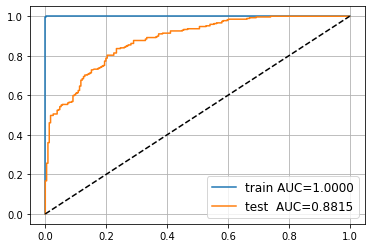

In [205]:
for name, X, y, model in [
    ('train', X_train_sk_tfidf.toarray(), y_train, tfidf_sk_model),
    ('test ', X_test_sk_tfidf.toarray(), y_test, tfidf_sk_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(tfidf_sk_model.predict(X_test_sk_tfidf.toarray()) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


### Solving it better: word vectors

Let's try another approach: instead of counting per-word frequencies, we shall map all words to pre-trained word vectors and average over them to get text features.

This should give us two key advantages: (1) we now have 10^2 features instead of 10^4 and (2) our model can generalize to word that are not in training dataset.

We begin with a standard approach with pre-trained word vectors. However, you may also try
* training embeddings from scratch on relevant (unlabeled) data
* multiplying word vectors by inverse word frequency in dataset (like tf-idf).
* concatenating several embeddings
    * call `gensim.downloader.info()['models'].keys()` to get a list of available models
* clusterizing words by their word-vectors and try bag of cluster_ids

__Note:__ loading pre-trained model may take a while. It's a perfect opportunity to refill your cup of tea/coffee and grab some extra cookies. Or binge-watch some tv series if you're slow on internet connection

In [206]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

# If you're low on RAM or download speed, use "glove-wiki-gigaword-100" instead. Ignore all further asserts.

In [207]:
def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.wv.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    
    #<YOUR CODE>
    for word in comment.split():
        try:
            features += embeddings.get_vector(word)
        except KeyError:
            pass
        
    #print (features.shape)    
    return features

#vectorize_sum("who cares anymore . they attack with impunity .") [::70]

assert np.allclose(
    vectorize_sum("who cares anymore . they attack with impunity .")[::70],
    np.array([ 0.0108616 ,  0.0261663 ,  0.13855131, -0.18510573, -0.46380025])
)

C:\Users\jose\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [208]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

C:\Users\jose\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


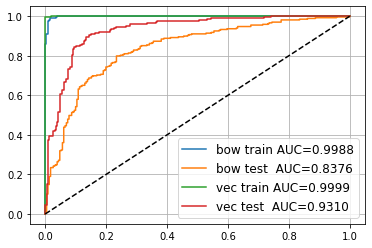

In [209]:
wv_model = LogisticRegression(max_iter=500).fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

If everything went right, you've just managed to reduce misclassification rate by a factor of two.
This trick is very useful when you're dealing with small datasets. However, if you have hundreds of thousands of samples, there's a whole different range of methods for that. We'll get there in the second part.